In [ ]:
import easyocr
import os
import cv2
import glob
import pandas as pd
import torch

class pre:
    def __init__(self, inputpath, savepath, imagepath, ground_truth):
        self.inputpath = inputpath # 잘라진 이미지(ocr할 이미지)의 경로
        self.savepath = savepath # 보정된 이미지가 저장될 경로
        self.imagepath = imagepath # ocr에 들어갈 이미지의 경로 ## 'savepath/image/' 꼴
        self.ground_truth = ground_truth

    # 이미지 보정
    def make_image(self):
        i = 0
        os.mkdir("{0}/image".format(self.savepath))
        for filename in glob.glob(self.inputpath + "*.jpg"):
            img = cv2.imread(filename)
            img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)  # DPI 300으로 설정
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  # black & white
            avg_blur = cv2.blur(binary, (5, 5))
            delation = cv2.dilate(avg_blur, (5, 5), iterations=1)
            i = i + 1
            cv2.imwrite(self.savepath + 'image/' + f'{i}.jpg', delation)

    # 보정된 이미지로 ocr 후 csv파일로 return
    def run_easyocr(self):
        val_img = os.listdir(self.imagepath)
        reader = easyocr.Reader(['ko'], gpu=True,
                                model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                                user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                                recog_network='custom')
        list =[]
        for f in val_img:
            result = reader.readtext(os.path.join(self.imagepath, f))
            text = ''
            for i in range(len(result)):
                text += result[i][1]
            list.append(text)
        easyocr_df = pd.DataFrame(list, columns = ['text'])
        easyocr_df['image'] = f
        easyocr_df.to_csv('easyocr_results.csv', index=False, encoding='utf-8-sig')
        
        #accuracy
        ground_truth_len = len(ground_truth)
        our_output_len = len(list)
        our_correct = 0
    
        for i in range(ground_truth_len):
            if ground_truth[i] == list[i]:
                our_correct += 1

        our_accuracy = our_correct / our_output_len
        print(our_accuracy)

In [ ]:
    result = reader.readtext(path_cur)
    text = ''
    for i in range(len(result)):
        text += result[i][1]
    recognized_text['0001'][file] = (text.replace(' ','').replace('\n',''))

In [ ]:
import pandas as pd
import easyocr
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


In [ ]:
word_based_exactly_matching(ground_truth, our_output)

In [ ]:
import pandas as pd
import easyocr
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


csvNamePath = r"D:\DTU-D\4\Fagprojekt\Data\Clean_Data\clean_en_train"
csv_data_1 = pd.read_csv(os.path.join(csvNamePath,"labels.csv"), sep="	")
csv_data_1["path"] = csv_data_1.shape[0]*[csvNamePath]

csvNamePath2 = r"D:\DTU-D\4\Fagprojekt\Data\Clean_Data\clean_en_val"
csv_data_2 = pd.read_csv(os.path.join(csvNamePath2,"labels.csv"), sep="	")
csv_data_2["path"] = csv_data_2.shape[0]*[csvNamePath2]

data = pd.concat([
    csv_data_1,
    csv_data_2
], ignore_index=True)

reader = easyocr.Reader(['en'])
batch = 1
rows = data.shape[0]

In [ ]:
results = []
ground_truth = []
correctIn = 0
for i in tqdm(range(rows)):
    if i % batch == 0:
        del reader
        torch.cuda.empty_cache()
        reader = easyocr.Reader(['en'])

    root_path = data.iloc[i]['path'].lower()
    image_name = data.iloc[i]['filename'].lower()
    path = os.path.join(root_path,image_name)

    result = reader.readtext(path, paragraph=True)
    results.append(result)

    #Dont judge me
    y = data.iloc[i]['words'].split(",")[0].replace("(", "").replace(")", "").replace(" ", "").replace("[","").replace("\"","").replace("]","").replace("\'","")
    ground_truth.append(y)
    for j in range(len(result)):
        if y in result[j]:
            correctIn += 1
            break
            
# import cv2
# result = reader.readtext(path, paragraph=True)
# # cv2.imdecode(np.fromfile(path, np.uint8), cv2.IMREAD_UNCHANGED).shape

print(f"pretrained accuracy: {(correctIn/rows)*100}")

# np.savez("Variables_results_08_04_2022_detailsOn_paragraphTrue",
#          correctIn=correctIn,
#          ground_truth=ground_truth
#          results=np.array(results,dtype=object))

# np.save("Results_07_06_2022_cropped_clean_data_original_model", np.array(results,dtype=object))

In [29]:
import torch
import cv2
import numpy as np
import easyocr
from helper.general_utils import save_results

# DEFINING GLOBAL VARIABLE
EASY_OCR = easyocr.Reader(['ko'], gpu=True,
                                model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                                user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                                recog_network='custom')
OCR_TH = 0.2

# -------------------------------------- function to run detection ---------------------------------------------------------
def detectx(frame, model):
    frame = [frame]
    print(f"[INFO] Detecting. . . ")
    results = model(frame)
    results.show()
    # print(results.xyxyn[0])
    # print(results.xyxyn[0][:, -1])
    # print(results.xyxyn[0][:, :-1])

    labels, cordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    return labels, cordinates


# ------------------------------------ to plot the BBox and results ---------------------------------------
def plot_boxes(results, frame, classes):
    labels, cord = results
    n = len(labels)
    x_shape, y_shape = frame.shape[1], frame.shape[0]
    print(f"[INFO] Total {n} detections. . . ")
    print(f"[INFO] Looping through all detections. . . ")

# -------------------------------------looping through the detections------------------------------------
    for i in range(n):
        row = cord[i]
        if row[4] >= 0.55:  ### threshold value for detection. We are discarding everything below this value
            print(f"[INFO] Extracting BBox coordinates. . . ")
            x1, y1, x2, y2 = int(row[0] * x_shape), int(row[1] * y_shape), int(row[2] * x_shape), int(
                row[3] * y_shape)  ## BBOx coordniates
            text_d = classes[int(labels[i])]
            #cv2.imwrite("dp.jpg",frame[int(y1):int(y2), int(x1):int(x2)])

            coords = [x1, y1, x2, y2]

            plate_num, accuracy = recognize_plate_easyocr(img=frame, coords=coords, reader=EASY_OCR, region_threshold=OCR_TH)

            print(f"result -> {plate_num}")
            # if text_d == 'mask':
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, ), 2)  ## BBox
            cv2.rectangle(frame, (x1, y1 - 20), (x2, y1), (0, 255, ), -2)  ## for text label background
            cv2.putText(frame, f"{plate_num}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            #cv2.imwrite("np.jpg",frame[int(y1)-25:int(y2)+25, int(x1)-25:int(x2)+25])

    return frame, plate_num, accuracy


# ---------------------------- function to recognize scratch card --------------------------------------

# function to recognize license plate numbers using Tesseract OCR
def recognize_plate_easyocr(img, coords, reader, region_threshold):
    # separate coordinates from box
    xmin, ymin, xmax, ymax = coords
    # get the subimage that makes up the bounded region and take an additional 5 pixels on each side
    # nplate = img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]
    nplate = img[int(ymin):int(ymax), int(xmin):int(xmax)]  ### cropping the number plate from the whole image

    ocr_result = reader.readtext(nplate)

    text, accuracy = filter_text(region=nplate, ocr_result=ocr_result, region_threshold=region_threshold)

    if len(text) == 1:
        text = text[0].upper()
    return text, accuracy

# to filter out wrong detections

def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0] * region.shape[1]

    scratch_card = []
    save_results(ocr_result[-1], 'ocr_results.csv', 'Detection_Images')
    print(ocr_result[0][-1])
    accuracy = str(ocr_result[0][-1])

    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))

        if length * height / rectangle_size > region_threshold:
            scratch_card.append(result[1])
    return scratch_card, accuracy


# ---------------------------------------------- Main function -----------------------------------------------------

def mainFun(img_path=None, vid_path=None, vid_out=None):
    print(f"[INFO] Loading model... ")
    ## loading the custom trained model
    # model =  torch.hub.load('ultralytics/yolov5', 'custom', path='last.pt',force_reload=True) ## if you want to download the git repo and then run the detection
    model = torch.hub.load('E:/yolov5-master', 'custom', source='local', path='best_card.pt',
                           force_reload=True)  ### The repo is stored locally

    classes = model.names  ### class names in string format

# --------------- for detection on image --------------------
    if img_path != None:
        print(f"[INFO] Working with image: {img_path}")
        # img_out_name = f"./output/result_{img_path.split('/')[-1]}"

        frame = cv2.imread(img_path)  ### reading the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = detectx(frame, model=model)  ### DETECTION HAPPENING HERE

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        frame, number, accuracy = plot_boxes(results, frame, classes=classes)
        # while True:
        #     #frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
        #     cv2.imwrite("img2.jpg", frame)
        #     break
        print(f"[INFO] Clening up. . . ")
        return number, accuracy
# -------------------  calling the main function-------------------------------
# mainFun(img_path="./test_images/3.jpg")  ## for image

ModuleNotFoundError: No module named 'grp'

In [4]:
def test(dir_path, model, reader):
    plates, plate_numbers = [], []
    for root, dirs, files in os.walk(dir_path):  
        for filename in files:
            plates.append(filename)

    for filename in plates:
        image = cv2.imread(f'{dir_path}/{filename}')    
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        result = model(img_gray)
        cordinates = result.xyxyn[0][:, :-1]
        width, height = image.shape[1], image.shape[0]

        for row in cordinates:
            x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)    
            read = reader.readtext(
                img_gray[y1:y2, x1:x2], 
                allowlist='0123456789АВЕКМНОРСТУХ'
            )

            plate = ''
            for i in range(len(read)):
                if i < 2 and read[i][-1] > 0.5:
                    plate += read[i][-2]
                elif read[i][-1] > 0.8:
                    plate += read[i][-2]

            plate_numbers.append(plate)
    return plate_numbers

In [5]:
target = ['김혜림',
           '82.11.15',
           '청주시 흥덕구 오송생명 14로 215. 107동 301호',
           '010-1234-5678',
           '여',
           '국립중앙인체자원은행',
           '043-719-6531',
           '2022년 12월 26일',
           '김혜림',
           '이미희',
           '김혜림',
           '82.11.15',
           '오송생명 14로 215. 107동 301호',
           '010-1234-5678',
           '여',
           '홍길동',
           '043-719-1234',
           '2022년 12월 26일',
           '김혜림',
           '이미희',
           '김혜림',
           '2022.12.26',
           '홍길동']

In [10]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [18]:
reader = easyocr.Reader(['ko'], gpu=True,
                                model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                                user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                                recog_network='custom')

model = torch.hub.load(
    'yolov5', 
    'custom',                  
    path='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir/custom.pth', 
    force_reload=True,
    source='local'
)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
YOLOv5  v7.0-72-g064365d Python-3.9.12 torch-1.13.1+cpu CPU



Exception: 'model'. Cache may be out of date, try `force_reload=True` or see https://github.com/ultralytics/yolov5/issues/36 for help.

In [ ]:
custom = test('/content/test', model, reader)

In [9]:
for i in range(len(custom)):
    if custom[i] == '':
        custom[i] = 'none'
cer_custom = cer(custom, target)
wer_custom = wer(custom, target)

NameError: name 'custom' is not defined

In [ ]:
def accuracy(graund_trought, predict):
    sum = 0
    for i in range(len(graund_trought)):
        sum += int(graund_trought[i] == predict[i])
    return sum / len(graund_trought)

In [ ]:
print('custom easyocr:')
print(f'accuracy: {accuracy(custom, target)}')

In [19]:
import easyocr
from sklearn.metrics import accuracy_score
import os
import shutil
import json
import itertools
import cv2
import glob
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt 
import requests
from PIL import Image
import pandas as pd

In [ ]:
#이미지 가져오기
img = cv2.imread(img_path)
print(img.shape)

In [ ]:
# ocr의 표준 권장 해상도는 300dpi (600dpi를 초과하면 이미지 크기만 증가, 처리시간만 늘어날뿐 정확도 개선은 X) 
# 이미지 크기 재조정
img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)

In [ ]:
#흑백 변환
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # color -> grayscale
binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU) # grascale -> binary
#노이즈 제거
gaussianblur = cv2.GaussianBlur(binary, (3, 3), 0) 
bilateralfilter = cv2.bilateralFilter(gaussianblur, 9, 75, 75)
edgepreservingfilter = cv2.edgePreservingFilter(bilateralfilter, flags=1, sigma_s=45, sigma_r=0.2)

In [ ]:
#canny 엣지 검출
canny = cv2.Canny(edgepreservingfilter, 75, 200, True)

In [ ]:
#모폴로지 연산
kernel = np.ones((3, 1), np.uint8)
src_morphology = cv2.morphologyEx(canny, cv2.MORPH_OPEN, kernel)

---------------------

In [2]:
## 0. DPI을 300으로 설정

In [3]:
## 1: Grayscale image: BGR(blue + green + red)을 GRAY로 색상을 바꾸는 작업
#Grayscale 
def get_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
## 2: grayscale로 변환한 이미지를 흑백(이진화) 이미지로 바꾸는 작업
#Binary(black & white)
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [93]:
##3: Blur 처리: 이미지의 노이즈를 제거하는 작업

# 평균 블러링(Average Blurring)
# 모든 픽셀에 동일한 가중치 부여
def avg_blur(image, kernel_size=(5,5)):
    return cv2.blur(image, kernel_size)

# 가우시안 블러링(Gaussian Blurring)
# 중심에 있는 픽셀에 높은 가중치 부여
def gau_blur(image, kernel_size=(5,5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# 미디언 블러링(Median Blurring)
# 커널 크기 내 픽셀을 크기 순으로 정렬 후 중간값을 뽑아 픽셀로 사용
def median_blur(image, kernel_size=5):
    return cv2.medianBlur(image, ksize=kernel_size)

#양방향 필터
def bilateral_blur(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

#가장자리 보존 필터
def edgepreserving_blur(image):
    return cv2.edgePreservingFilter(image, flags=1, sigma_s=45, sigma_r=0.2)

In [6]:
## 4: Morphology 변환: 이미지의 특정 부분을 조건에 맞춰 변환하는 작업

# Dilation(팽창)
# 객체 외곽 픽셀 주변에 1(흰색) 추가 -> 이미지 경계를 기준으로 팽창하는 효과 발생
def delation(image):
    kernel = np.ones((5,5), np.unit8)
    result = cv2.dilate(image, kernel, iterations=1)
    return result
    
# Erosion(침식)
# 객체 외곽 픽셀 주변에 0(검은색) 추가 -> 이미지 경계를 기준으로 침식하는 효과 발생
def erosion(image):
    kernel = np.ones((5,5), np.uint8)
    result = cv2.erode(image, kernel, iterations=1)
    return result 
    
# Opening(침식 -> 팽창)
# 이미지 상의 작은 잡티, 물체 등을 제거하는 효과 발생
def open(image):
    kernel = np.ones((5,5), np.uint8)
    result = cv2.morphologyEx(image, cv.MORPH_OPEN, kernel)
    return result
    
# Closing(팽창 -> 침식)
# 전체적인 윤곽을 뚜렷하게 보이는 효과 발생
def close(image):
    kernel = np.ones((5,5), np.unit8)
    result = cv2.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    return result

In [56]:
## 이미지 가져오기

# TRY 1
path = 'C:/Users/USER/PycharmProjects/ocr/cropped/' #폴더경로
os.chdir(path) # 해당 폴더로 이동
files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음

In [96]:
print(files)

['cropped_10_0.jpg', 'cropped_10_1.jpg', 'cropped_10_2.jpg', 'cropped_10_3.jpg', 'cropped_10_4.jpg', 'cropped_10_5.jpg', 'cropped_10_6.jpg', 'cropped_11_0.jpg', 'cropped_11_1.jpg', 'cropped_11_3.jpg', 'cropped_12_0.jpg', 'cropped_12_1.jpg', 'cropped_12_2.jpg', 'cropped_12_3.jpg', 'cropped_12_4.jpg', 'cropped_12_8.jpg', 'cropped_12_9.jpg', 'cropped_13_0.jpg', 'cropped_13_1.jpg', 'cropped_13_3.jpg', 'cropped_7_0.jpg', 'cropped_7_2.jpg', 'cropped_7_7.jpg']


In [97]:
for file in files:
    f = cv2.imread('C:/Users/USER/PycharmProjects/ocr/cropped/'+ file)

In [98]:
f

array([[[255, 255, 255],
        [255, 255, 255],
        [254, 254, 254],
        ...,
        [246, 246, 246],
        [249, 249, 249],
        [253, 253, 253]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [247, 247, 247],
        [249, 249, 249],
        [254, 254, 254]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [248, 248, 248],
        [246, 246, 246],
        [252, 252, 252]],

       ...,

       [[249, 253, 247],
        [249, 253, 247],
        [250, 254, 248],
        ...,
        [254, 253, 255],
        [254, 253, 255],
        [255, 254, 255]],

       [[255, 255, 244],
        [255, 255, 244],
        [255, 255, 244],
        ...,
        [255, 254, 255],
        [255, 254, 255],
        [255, 254, 255]],

       [[235, 228, 213],
        [235, 228, 213],
        [235, 228, 213],
        ...,
        [255, 254, 255],
        [255, 254, 255],
        [255, 254, 255]]

<function matplotlib.pyplot.show(close=None, block=None)>

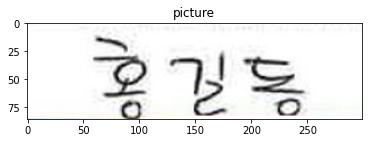

In [102]:
# 이미지 크기 재조정(300dpi)
img = cv2.resize(f, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('picture')
plt.show

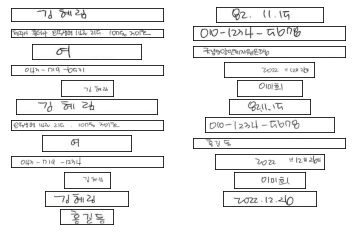

In [128]:
# TRY 2
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
rows = 12
cols = 2
i = 1

for filename in glob.glob("C:/Users/USER/PycharmProjects/ocr/cropped/*.jpg"):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) # fx, fy: 가로, 세로 사이즈의 배수
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
 
plt.show()

In [136]:
# TRY 3
pre_file_path = 'C:/Users/USER/PycharmProjects/ocr/cropped_pre/' # 이미지가 저장될 폴더 경로
list_images = glob.glob("C:/Users/USER/PycharmProjects/ocr/cropped/*.jpg") # 타겟 폴더에서 jpg 파일의 경로들을 리스트로 저장
i = 0 # 파일 이름 저장 시 변경해줄 번호
for filename in list_images: # 반복을 위한 for문
    img = Image.open(filename)
    i = i+1
    img.save(pre_file_path + f'{i}.jpg', dpi=(300.0, 300.0))

In [145]:
## 최종 structure
# input path, save path를 주면 전처리된 이미지를 리턴
input_path = 'C:/Users/USER/PycharmProjects/ocr/cropped/'
save_path = 'C:/Users/USER/PycharmProjects/ocr/save_image/' 
i = 0
for filename in glob.glob(input_path +"*.jpg"):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    GaussianBlur = cv2.GaussianBlur(binary, (7, 7), 3)
    i = i+1
    cv2.imwrite(save_path + f'{i}.jpg', GaussianBlur)

여러 조합으로 실험 후 가장 좋은 결과를 보인 전처리 과정을 main.py 클래스 안에 추가할 예정

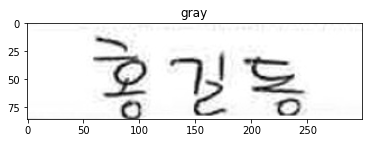

In [81]:
# gray scale 
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.title('gray')
plt.show()

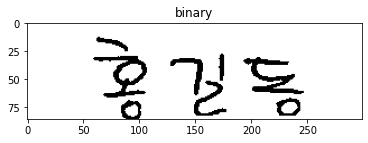

In [82]:
# 흑백 변환
binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.imshow(binary, cmap='gray')
plt.title('binary')
plt.show()

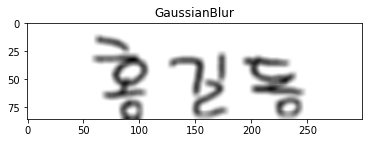

In [86]:
# 가우시안 필터 
# 노이즈가 있는 이미지가 아니라서 블러처리는 안해도 될 듯
GaussianBlur = cv2.GaussianBlur(binary, (7, 7), 3)
plt.imshow(GaussianBlur, cmap='gray')
plt.title('GaussianBlur')
plt.show()

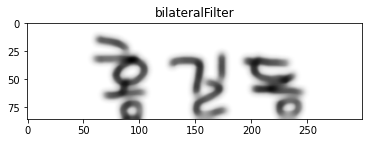

In [87]:
bilateralFilter=cv2.bilateralFilter(GaussianBlur, 9, 75, 75)
plt.imshow(bilateralFilter, cmap='gray')
plt.title('bilateralFilter')
plt.show() 

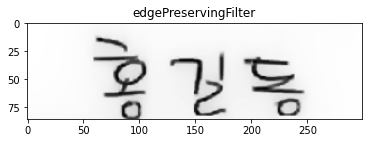

In [91]:
edgePreservingFilter=cv2.edgePreservingFilter(gray, flags=1, sigma_s=45, sigma_r=0.2)
plt.imshow(edgePreservingFilter, cmap='gray')
plt.title('edgePreservingFilter')
plt.show() 

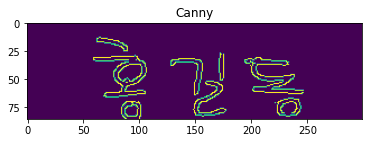

In [92]:
plt.imshow(cv2.Canny(edgePreservingFilter, 75, 200, True))
plt.title('Canny')
plt.show()

In [146]:
gt_list = ['김혜림',
           '82.11.15',
           '청주시 흥덕구 오송생명 14로 215. 107동 301호',
           '010-1234-5678',
           '여',
           '국립중앙인체자원은행',
           '043-719-6531',
           '2022년 12월 26일',
           '김혜림',
           '이미희',
           '김혜림',
           '82.11.15',
           '오송생명 14로 215. 107동 301호',
           '010-1234-5678',
           '여',
           '홍길동',
           '043-719-1234',
           '2022년 12월 26일',
           '김혜림',
           '이미희',
           '김혜림',
           '2022.12.26',
           '홍길동']

In [163]:
IMG_PATH = r'C:\Users\USER\PycharmProjects\ocr\cropped'
val_img = os.listdir(IMG_PATH)
reader = easyocr.Reader(['ko'], gpu=True)
for f in val_img:
    result = reader.readtext(os.path.join(IMG_PATH, f))
    img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
    predict_list = list(img_df['text'])
    print(predict_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['김 혜립']
['똑2', '((, (다']
['%꾸시   흉', '*상면 ((고', '리다', '(0,논 201볼']
['0(-(2 나', '-', '다67안']
[]
['굶갑룹이인저[자원은다0']
['0나거 - 719', '시4쥐 1']
['722', '년', '(?월 라일']
['기', '예4']
['이미희']
['기 혀 라']
["영리(-'다"]
['(헌생 명', '(4라', '리다', '[00논', '3011']
['0(0- (234', '', '다67안']
[]
['홍길 또']
['04거', '1 (9', '[234']
['72', '년 (고월 리일']
['길 혀림']
['이미후(']
['기 5리']
['7시2', '(2']
['홍긴등']


In [164]:
IMG_PATH = r'C:\Users\USER\PycharmProjects\ocr\cropped_pre'
val_img = os.listdir(IMG_PATH)
reader = easyocr.Reader(['ko'], gpu=True)
for f in val_img:
    result = reader.readtext(os.path.join(IMG_PATH, f))
    img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
    predict_list = list(img_df['text'])
    print(predict_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['김 혜립']
['이미희']
['기 혀 라']
["리(-'다"]
['(헌생 명', '(4라', '리다', '[00논', '"이구']
['[(0-1234 - 다67안']
[]
['@길 동']
['04거', '1 (9', '[234']
['2 22', '년 (고월 리일']
['길 혀4']
['똑2', '((. (다']
['이미후']
['기 5리']
['702', '(2', '2']
['홍기등']
['%꾸시   흉', '만상명 ((꽤 리다', '(0,논 2012']
['0(-(2, 나', '-', '다67양']
[]
['굳추증이인저자원은다0']
['0나거', '-', '79', '시4쥐 1']
['7시22', '년', '(?월 라']
['7', '예4']


In [3]:
IMG_PATH = r'C:\Users\USER\PycharmProjects\ocr\cropped'
val_img = os.listdir(IMG_PATH)
reader = easyocr.Reader(['ko'], gpu=True,
                    model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                    user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                    recog_network='custom')
for f in val_img:
    result = reader.readtext(os.path.join(IMG_PATH, f))
    img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
    predict_list = list(img_df['text'])
    print(predict_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['김혜험']
['용고', '내']
['최꾸시홍터가', '민족생명요', '리다', '매동주이원']
['이꺼고주나', '역', '디미마']
[]
['굳칼망인체지원은매시']
['애구미미', '바귀']
['근성', '년', '오고콜라빛']
['김', '혜림']
['이미회']
['김혜대']
['없나']
['연따생명', '나켓', '리다', '매름', '각미초']
['미어고주나', '미', '다머가업']
[]
['름일통']
['아나주', '미억', '머구나']
['래다', '비오리있']
['김혜럼']
['미미회']
['김혜림']
['근선', '[그']
['홍질등']


In [31]:
class preprocessing:
    def __init__(self, inputpath, savepath,imagepath):
        self.inputpath = inputpath
        self.savepath = savepath
        self.imagepath = imagepath
    
    # 이미지 보정
    def make_image(self):
        i = 0
        os.mkdir("{0}/gb".format(self.savepath))
        for filename in glob.glob(self.inputpath +"*.jpg"):
            img = cv2.imread(filename)
            img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) # DPI 300으로 설정
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grayscale
            binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # black & white
            avg_blur = cv2.blur(binary, (5,5)) 
            delation = cv2.dilate(avg_blur, (5,5), iterations=1)
            i = i+1
            cv2.imwrite(self.savepath + f'{i}.jpg', delation)
    
    # 보정된 이미지로 OCR
    def img_ocr(self):
        val_img = os.listdir(self.imagepath)
        reader = easyocr.Reader(['ko'], gpu=True,
                            model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                            user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                            recog_network='custom')
        for f in val_img:
            result = reader.readtext(os.path.join(self.imagepath, f))
            img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
            predict_list = list(img_df['text'])
        return print(predict_list)

In [33]:
a = preprocessing(r"C:\Users\USER\PycharmProjects\ocr\cropped",r"C:\Users\USER\PycharmProjects\ocr\imagepreprocessing",r"C:\Users\USER\PycharmProjects\ocr\imagepreprocessing\grad")
img = a.make_image()
ocr = a.img_ocr

그레이 + 흑백 + 평균 + 팽창

In [11]:
input_path = 'C:/Users/USER/PycharmProjects/ocr/cropped/'
save_path = 'C:/Users/USER/PycharmProjects/ocr/imagepreprocessing/' 
i = 0
os.mkdir("{0}/gbaa".format(save_path))
for filename in glob.glob(input_path +"*.jpg"):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    avg_blur = cv2.blur(binary, (5,5)) 
    delation = cv2.dilate(avg_blur, (5,5), iterations=1)
    i = i+1
    cv2.imwrite(save_path +'gbad/' + f'{i}.jpg', delation)

In [28]:
IMG_PATH = r'C:\Users\USER\PycharmProjects\ocr\imagepreprocessing\gbad'
val_img = os.listdir(IMG_PATH)
reader = easyocr.Reader(['ko'], gpu=True,
                    model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                    user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                    recog_network='custom')
for f in val_img:
    result = reader.readtext(os.path.join(IMG_PATH, f))
    img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
    predict_list = list(img_df['text'])
    print(predict_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['김혜험']
['이미회']
['김', '혜램']
['없']
['인체생명', '바켓', '리다', '매동', '거미기모']
['미여고주니', '다업']
['여']
['름길', '통']
['애주', '평려', '미의', '해다', '따']
['끊', '비교리교']
['김혜림']
['용고', '시시어']
['미미회']
['김혜림']
['근생', '머고리 ']
['홍걷통']
['최주시찌가', '브명바밀리다', '매도주이모']
['이어고나다업']
['여']
['굳잡영양인제지원문매시']
['애주', '빼', '미의', '방귀']
['근마', '년라']
['김혜림']


그레이 + 흑백 + 평균 + 침식

In [9]:
input_path = 'C:/Users/USER/PycharmProjects/ocr/cropped/'
save_path = 'C:/Users/USER/PycharmProjects/ocr/imagepreprocessing/' 
i = 0
os.mkdir("{0}/gbae".format(save_path))
for filename in glob.glob(input_path +"*.jpg"):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    avg_blur = cv2.blur(binary, (5,5)) 
    erosion = cv2.erode(avg_blur, (5,5), iterations=1)
    i = i+1
    cv2.imwrite(save_path +'gbae/' + f'{i}.jpg', erosion)

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'C:/Users/USER/PycharmProjects/ocr/imagepreprocessing//gbae'

In [ ]:
IMG_PATH = r'C:\Users\USER\PycharmProjects\ocr\imagepreprocessing\gbmd'
val_img = os.listdir(IMG_PATH)
reader = easyocr.Reader(['ko'], gpu=True,
                    model_storage_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                    user_network_directory='C:/Users/USER/PycharmProjects/ocr/workspace/user_network_dir',
                    recog_network='custom')
for f in val_img:
    result = reader.readtext(os.path.join(IMG_PATH, f))
    img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
    predict_list = list(img_df['text'])
    print(predict_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['김', '혜험']
['이미회']


In [13]:
input_path = 'C:/Users/USER/PycharmProjects/ocr/cropped/'
save_path = 'C:/Users/USER/PycharmProjects/ocr/imagepreprocessing/' 
i = 0
os.mkdir("{0}/gb".format(save_path))
for filename in glob.glob(input_path +"*.jpg"):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    median_blur = cv2.medianBlur(binary, ksize=5)
    erosion = cv2.erode(median_blur, (5,5), iterations=1)
    i = i+1
    cv2.imwrite(save_path +'gb/' + f'{i}.jpg', erosion)

In [ ]:
import easyocr
import os
from sklearn.metrics import accuracy_score
import shutil
import json
import itertools
import cv2
import glob
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt 
import requests
from PIL import Image
import pandas as pd
import tensorflow as tf
import faulthandler

faulthandler.enable()

class ocr:
    def __init__(self, IMG_PATH):
        self.IMG_PATH = IMG_PATH

    def run_easyocr(self):
        val_img = os.listdir(self.IMG_PATH)
        reader = easyocr.Reader(['ko'], gpu=True)
        dfs = []
        for f in val_img:
            result = reader.readtext(os.path.join(self.IMG_PATH, f))
            print(result)
            img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
            img_df['image'] = f
            dfs.append(img_df)
            if len(dfs) % 20 == 0:
                print('easyocr done: ', len(dfs))
        easyocr_df = pd.concat(dfs)
        easyocr_df.to_csv('easyocr_results.csv', index=False, encoding='utf-8-sig')

a=ocr(r'C:\Users\USER\PycharmProjects\ocr\workspace_aihubdata\demo_images')
a.run_easyocr()

In [25]:
class pre:
    def __init__(self, inputpath, savepath,imagepath):
        self.inputpath = inputpath
        self.savepath = savepath
        self.imagepath = imagepath

    # 이미지 보정
    def make_image(self):
        i = 0
        os.mkdir("{0}/image".format(self.savepath))
        for filename in glob.glob(self.inputpath +"*.jpg"):
            img = cv2.imread(filename)
            img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) # DPI 300으로 설정
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # black & white
            avg_blur = cv2.blur(binary, (5,5)) 
            delation = cv2.dilate(avg_blur, (5,5), iterations=1)
            i = i+1
            cv2.imwrite(self.savepath +'image/' + f'{i}.jpg', delation)
    
    # 보정된 이미지로 ocr 후 csv파일로 return
    def run_easyocr(self):
        val_img = os.listdir(self.imagepath)
        reader = easyocr.Reader(['ko'], gpu=True)
        dfs = []
        for f in val_img:
            result = reader.readtext(os.path.join(self.imagepath, f))
            print(result)
            img_df = pd.DataFrame(result, columns=['bbox', 'text', 'conf'])
            img_df['image'] = f
            dfs.append(img_df)
            if len(dfs) % 20 == 0:
                print('easyocr done: ', len(dfs))
        easyocr_df = pd.concat(dfs)
        easyocr_df.to_csv('easyocr_results.csv', index=False, encoding='utf-8-sig')

In [26]:
a=pre('C:/Users/USER/PycharmProjects/ocr/cropped/',
     'C:/Users/USER/PycharmProjects/ocr/imagepreprocessing/',
     'C:/Users/USER/PycharmProjects/ocr/imagepreprocessing/image/')

In [27]:
a.make_image()

In [29]:
a.run_easyocr()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[123, 5], [373, 5], [373, 65], [123, 65]], ' 예림', 0.14150679111480713)]
[([[154, 10], [349, 10], [349, 84], [154, 84]], '이미희', 0.9895835351230753)]
[([[109, 9], [195, 9], [195, 77], [109, 77]], '7', 0.5249742699309223), ([[222, 10], [404, 10], [404, 66], [222, 66]], '헤 김', 0.3250131050762044)]
[([[95, 13], [295, 13], [295, 77], [95, 77]], "(리(-'다", 0.5669152199956563)]
[([[12, 6], [213, 6], [213, 79], [12, 79]], '(떼생영', 0.14858663082122803), ([[228, 18], [330, 18], [330, 66], [228, 66]], '(4라', 0.05801654755368553), ([[353, 21], [447, 21], [447, 65], [353, 65]], '리다', 0.9415249944496006), ([[557, 12], [709, 12], [709, 66], [557, 66]], '(00유', 0.1541651487350464), ([[728, 7], [912, 7], [912, 68], [728, 68]], '거이크', 0.07881600798191138)]
[([[17, 15], [296, 15], [296, 82], [17, 82]], '0(0- 1234', 0.662294320407206), ([[339, 15], [517, 15], [517, 75], [339, 75]], '[679', 0.2098737235261244)]
[([[150, 14], [202, 14], [202, 64], [150, 64]], '여', 0.739153719915123)]
[([[106, 0], [242, 0], 

In [ ]:
i = 0
os.mkdir("{0}/gbae".format(save_path))
for filename in glob.glob(input_path +"*.jpg"):
    img = cv2.imread(filename)
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    avg_blur = cv2.blur(binary, (5,5)) 
    erosion = cv2.erode(avg_blur, (5,5), iterations=1)
    i = i+1
    cv2.imwrite(save_path +'gbae/' + f'{i}.jpg', erosion)

In [ ]:
def make_image(self):
    i = 0
    os.mkdir("{0}/gb".format(self.savepath))
    for filename in glob.glob(self.inputpath +"*.jpg"):
        img = cv2.imread(filename)
        img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC) # DPI 300으로 설정
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # black & white
        avg_blur = cv2.blur(binary, (5,5)) 
        delation = cv2.dilate(avg_blur, (5,5), iterations=1)
        i = i+1
        cv2.imwrite(self.savepath + f'{i}.jpg', delation)